# DuckDB VS Dask-SQL

In [2]:
import os
import glob
import pyarrow.parquet as pq
import duckdb
import dask.dataframe as dd
from dask_sql import Context
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [3]:
# 1. Load parquet files safely
def load_parquets_safely(base_path):
    parquet_files = glob.glob(os.path.join(base_path, "**", "*.parquet"), recursive=True)
    valid_files = []
    bad_files = []
    for f in parquet_files:
        if os.path.getsize(f) == 0:
            bad_files.append(f)
            continue
        try:
            pq.ParquetFile(f)
            valid_files.append(f)
        except Exception:
            bad_files.append(f)
    print(f"Valid parquet files: {len(valid_files)}")
    print(f"Bad parquet files skipped: {len(bad_files)}")
    return valid_files

base_path = "/d/hpc/projects/FRI/bigdata/students/gk40784/bigdata_hw5_output/partitioned_augmented"
valid_files = load_parquets_safely(base_path)

desired_years = {"2018","2019", "2020", "2021","2022","2023"}
reduced_files = [f for f in valid_files if any(f"year={year}" in f for year in desired_years)]
print(f"Files after reduction: {len(reduced_files)}")

Valid parquet files: 147
Bad parquet files skipped: 0
Files after reduction: 107


# DuckDB

In [3]:
# DuckDB connection
con = duckdb.connect()

def run_duckdb_query(sql):
    start = time.time()
    df = con.execute(sql).df()
    print(f"DuckDB query took {time.time() - start:.2f}s")
    print(df.head())
    return df

def create_duckdb_table_for_year(year):
    year_files = [f for f in reduced_files if f"year={year}" in f]
    if not year_files:
        print(f"No parquet files found for year {year}")
        return
    
    files_str = ", ".join(f"'{file}'" for file in year_files)
    
    con.execute(f"""
    CREATE OR REPLACE TABLE taxi_data_{year} AS
    SELECT *, 
      CASE
        WHEN year = 2018 THEN 'Pre-pandemic'
        WHEN year = 2020 THEN 'During pandemic'
        WHEN year = 2022 THEN 'Post-pandemic'
        ELSE 'Other'
      END AS pandemic_period
    FROM parquet_scan([{files_str}])
    """)
    print(f"DuckDB table for year {year} created.")


--- Year: 2018 ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB table for year 2018 created.
DuckDB query took 1.61s
  pandemic_period  is_holiday  trip_count
0    Pre-pandemic        True     3221061
1    Pre-pandemic       False    99649463
DuckDB query took 0.13s
              holiday_name  trip_count
0     Susan B. Anthony Day      322954
1       Lincoln's Birthday      287958
2             Election Day      277709
3  Veterans Day (observed)      260731
4             Veterans Day      258032
DuckDB query took 1.01s
  pickup_date  avg_temp_c  avg_precip_mm  trip_count
0  2018-01-01        -8.6            0.0      237184
1  2018-01-02        -6.0            0.0      238181
2  2018-01-03        -4.0            0.0      267006
3  2018-01-04        -2.9           18.0      122223
4  2018-01-05        -8.1            0.0      265260


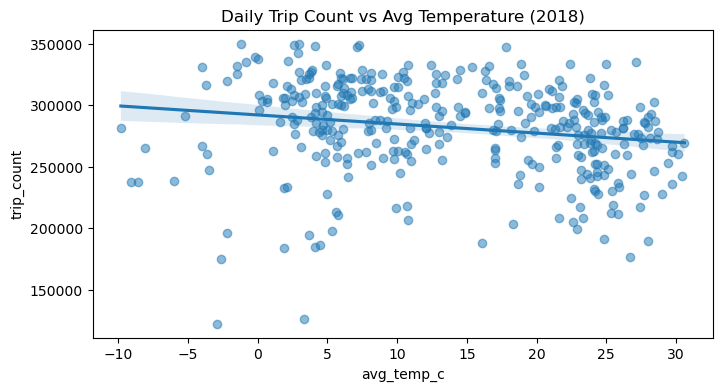

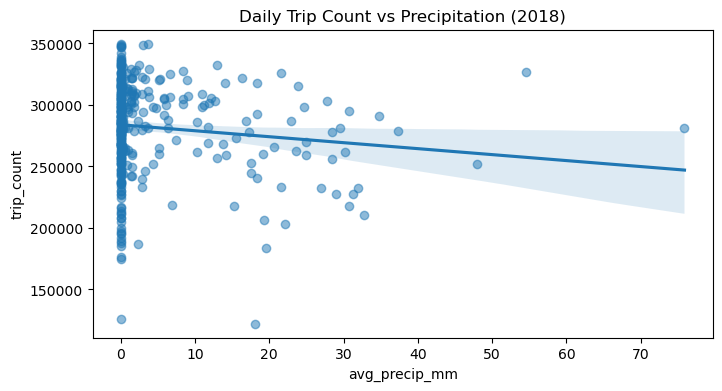

Year 2018:
  Pearson correlation avg_temp_c vs trip_count: -0.188 (p=0.000293)
  Pearson correlation avg_precip_mm vs trip_count: -0.119 (p=0.0226)
--- Year: 2020 ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB table for year 2020 created.
DuckDB query took 0.48s
   pandemic_period  is_holiday  trip_count
0  During pandemic        True     1181720
1  During pandemic       False    23467546
DuckDB query took 0.04s
                 holiday_name  trip_count
0          Lincoln's Birthday      236432
1        Susan B. Anthony Day      202205
2              New Year's Day      169444
3  Martin Luther King Jr. Day      161959
4       Washington's Birthday      148846
DuckDB query took 0.24s
  pickup_date  avg_temp_c  avg_precip_mm  trip_count
0  2020-01-01         3.6            0.0      169444
1  2020-01-02         4.7            0.0      162168
2  2020-01-03         7.6            2.8      183479
3  2020-01-04         8.2            5.3      182765
4  2020-01-05         4.6            0.0      164404


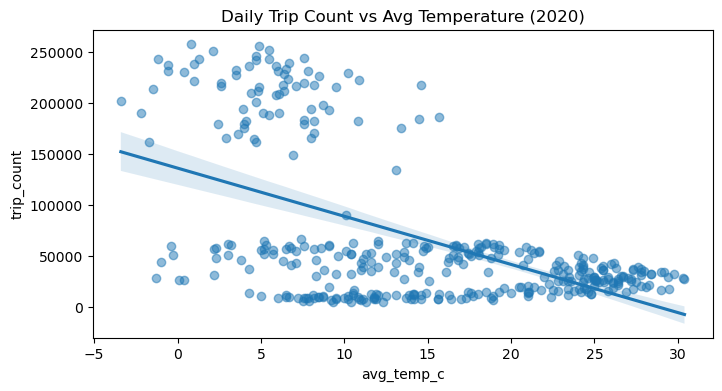

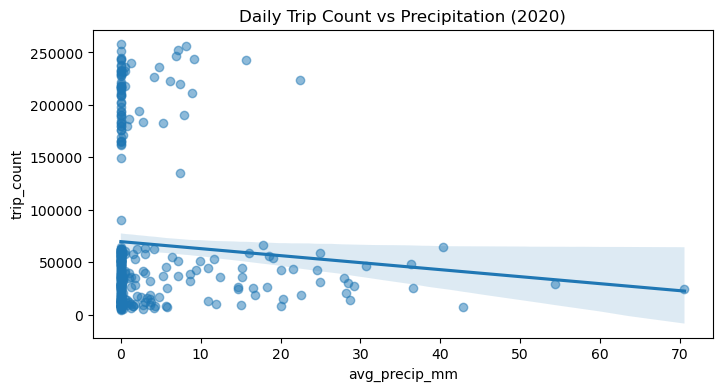

Year 2020:
  Pearson correlation avg_temp_c vs trip_count: -0.544 (p=1.61e-29)
  Pearson correlation avg_precip_mm vs trip_count: -0.076 (p=0.149)
--- Year: 2022 ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB table for year 2022 created.
DuckDB query took 0.76s
  pandemic_period  is_holiday  trip_count
0   Post-pandemic        True     1509841
1   Post-pandemic       False    38145781
DuckDB query took 0.06s
                    holiday_name  trip_count
0                   Election Day      121121
1             Lincoln's Birthday      119686
2  Lincoln's Birthday (observed)      117752
3                   Veterans Day      117728
4           Susan B. Anthony Day      110484
DuckDB query took 0.40s
  pickup_date  avg_temp_c  avg_precip_mm  trip_count
0  2022-01-01         9.7           24.0       63454
1  2022-01-02         9.1            5.2       58421
2  2022-01-03        -1.9            2.5       72408
3  2022-01-04        -2.8            0.0       74562
4  2022-01-05         3.0            3.3       74592


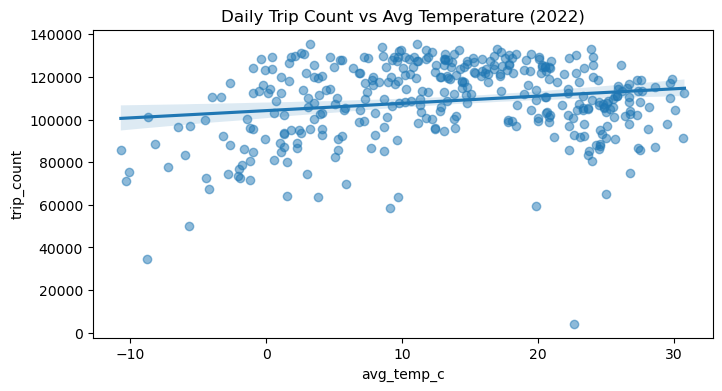

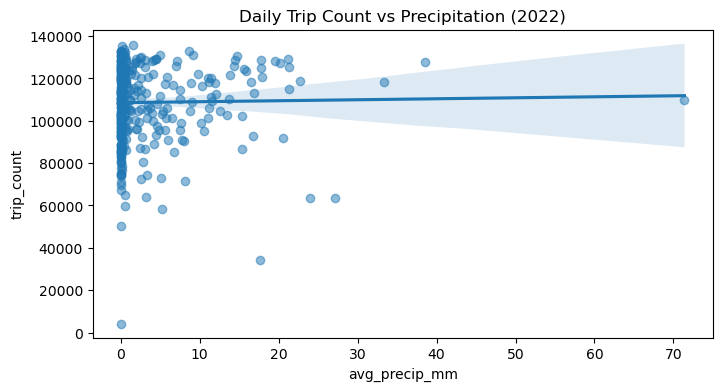

Year 2022:
  Pearson correlation avg_temp_c vs trip_count: 0.184 (p=0.000408)
  Pearson correlation avg_precip_mm vs trip_count: 0.017 (p=0.744)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

years = [2018, 2020, 2022]

df_total_trips = []
df_top_holidays = []

for i, year in enumerate(years):
    print(f"--- Year: {year} ---")
    create_duckdb_table_for_year(year)

    # 1. Total trips holiday vs non-holiday
    sql1 = f"""
    SELECT pandemic_period, is_holiday, COUNT(*) AS trip_count
    FROM taxi_data_{year}
    GROUP BY pandemic_period, is_holiday
    ORDER BY pandemic_period, is_holiday DESC
    """
    df1 = run_duckdb_query(sql1)
    df1['year'] = year
    df_total_trips.append(df1)

    # 2. Top 5 holidays
    sql2 = f"""
    SELECT holiday_name, COUNT(*) AS trip_count
    FROM taxi_data_{year}
    WHERE is_holiday = TRUE
    GROUP BY holiday_name
    ORDER BY trip_count DESC
    LIMIT 5
    """
    df2 = run_duckdb_query(sql2)
    df2['year'] = year
    df_top_holidays.append(df2)


    # 3. Weather impact: daily avg temp & precipitation vs trip counts
    sql3 = f"""
    SELECT
      pickup_date,
      AVG(avg_temp_c) AS avg_temp_c,
      AVG(precip_mm) AS avg_precip_mm,
      COUNT(*) AS trip_count
    FROM taxi_data_{year}
    WHERE pickup_date IS NOT NULL
    GROUP BY pickup_date
    ORDER BY pickup_date
    """
    df3 = run_duckdb_query(sql3)

    # Scatterplots with regression lines
    plt.figure(figsize=(8,4))
    sns.regplot(data=df3, x='avg_temp_c', y='trip_count', scatter_kws={'alpha':0.5})
    plt.title(f'Daily Trip Count vs Avg Temperature ({year})')
    plt.show()

    plt.figure(figsize=(8,4))
    sns.regplot(data=df3, x='avg_precip_mm', y='trip_count', scatter_kws={'alpha':0.5})
    plt.title(f'Daily Trip Count vs Precipitation ({year})')
    plt.show()

    # Correlations
    temp_corr, temp_p = pearsonr(df3['avg_temp_c'], df3['trip_count'])
    precip_corr, precip_p = pearsonr(df3['avg_precip_mm'], df3['trip_count'])
    print(f"Year {year}:")
    print(f"  Pearson correlation avg_temp_c vs trip_count: {temp_corr:.3f} (p={temp_p:.3g})")
    print(f"  Pearson correlation avg_precip_mm vs trip_count: {precip_corr:.3f} (p={precip_p:.3g})")

    if i > 0:
        prev_year = years[i-1]
        con.execute(f"DROP TABLE IF EXISTS taxi_data_{prev_year}")

# Optionally concatenate dfs at the end if you want combined plots later
df_total_trips_all = pd.concat(df_total_trips)
df_top_holidays_all = pd.concat(df_top_holidays)

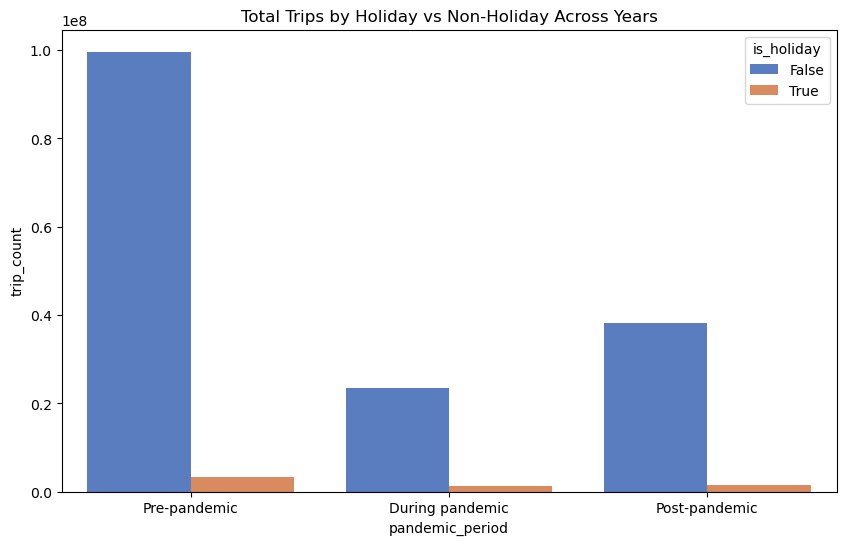

In [5]:
# Plot Total Trips side-by-side
plt.figure(figsize=(10,6))
sns.barplot(data=df_total_trips_all, x='pandemic_period', y='trip_count', hue='is_holiday', palette='muted')
plt.title("Total Trips by Holiday vs Non-Holiday Across Years")
plt.show()

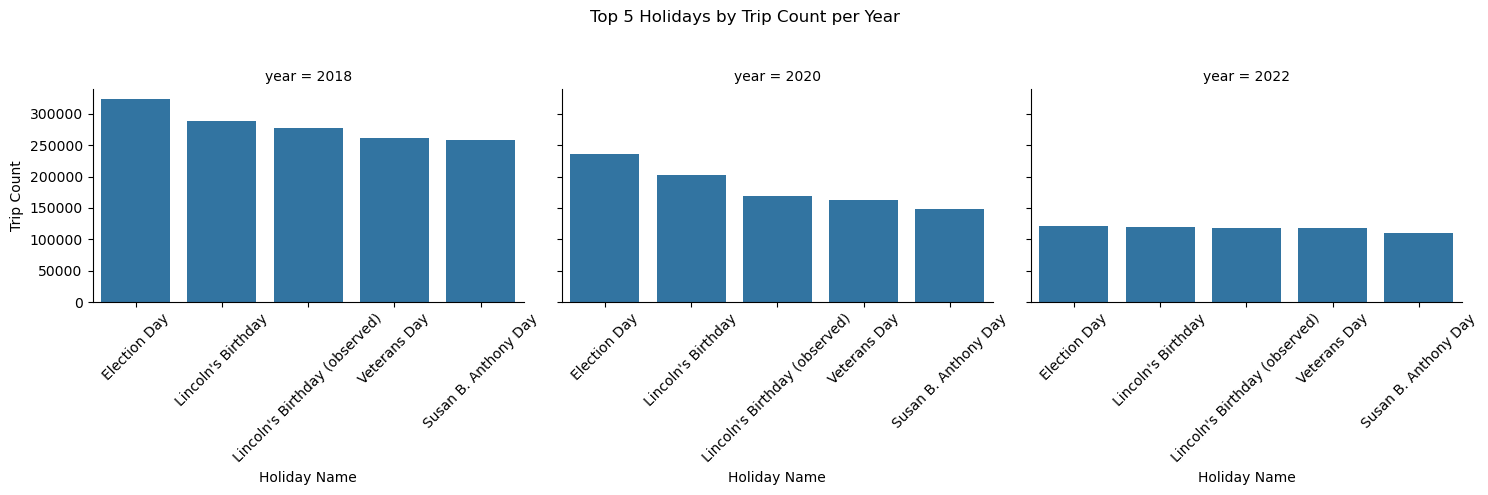

In [6]:
g = sns.FacetGrid(df_top_holidays_all, col="year", sharey=True, height=5, aspect=1, palette='muted')
g.map_dataframe(sns.barplot, x='holiday_name', y='trip_count')
g.set_xticklabels(rotation=45)
g.set_axis_labels("Holiday Name", "Trip Count")
g.fig.suptitle("Top 5 Holidays by Trip Count per Year")
g.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Dask-SQL

In [4]:
def run_dask_sql_query(sql):
    start = time.time()
    df = c.sql(sql).compute()
    print(f"Dask-SQL query took {time.time() - start:.2f}s")
    print(df.head())
    return df

--- Year: 2018 ---
Dask-SQL query took 7.26s
Dask-SQL query took 33.36s
Dask-SQL query took 35.27s


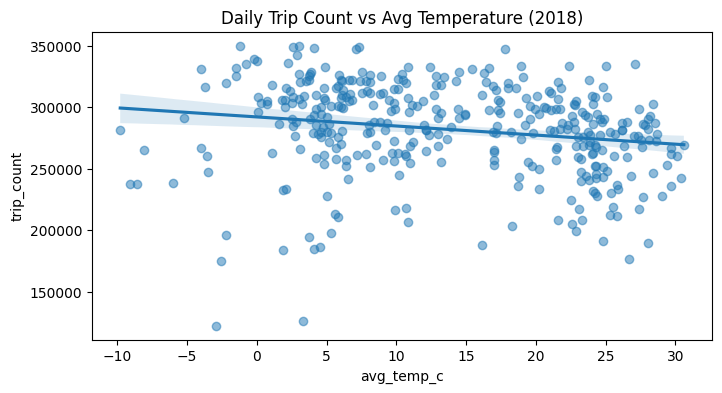

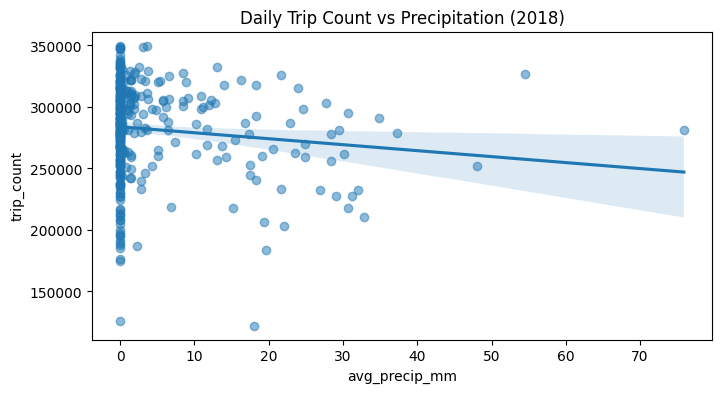

Year 2018:
  Pearson correlation avg_temp_c vs trip_count: -0.188 (p=0.000293)
  Pearson correlation avg_precip_mm vs trip_count: -0.119 (p=0.0226)
--- Year: 2020 ---
Dask-SQL query took 1.77s
Dask-SQL query took 9.44s
Dask-SQL query took 9.68s


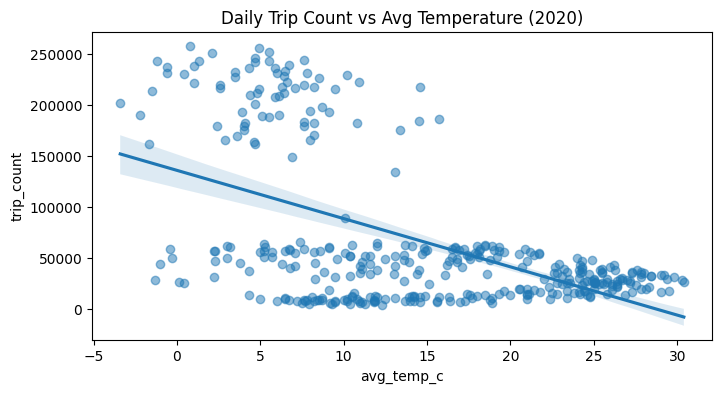

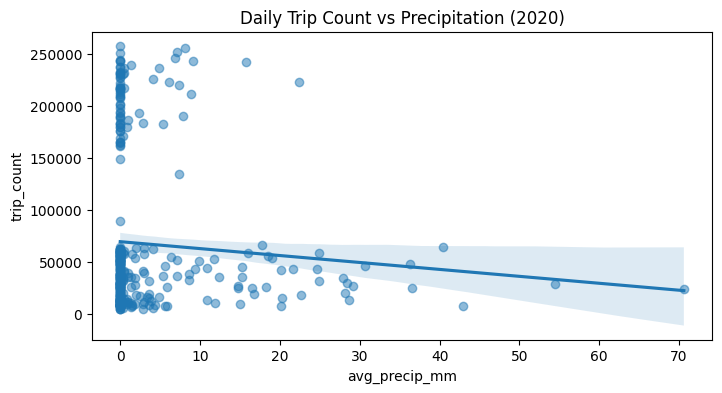

Year 2020:
  Pearson correlation avg_temp_c vs trip_count: -0.544 (p=1.61e-29)
  Pearson correlation avg_precip_mm vs trip_count: -0.076 (p=0.149)
--- Year: 2022 ---
Dask-SQL query took 2.69s
Dask-SQL query took 14.09s
Dask-SQL query took 14.64s


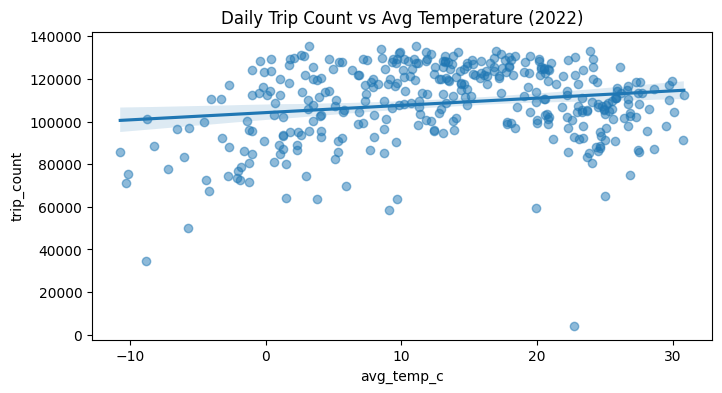

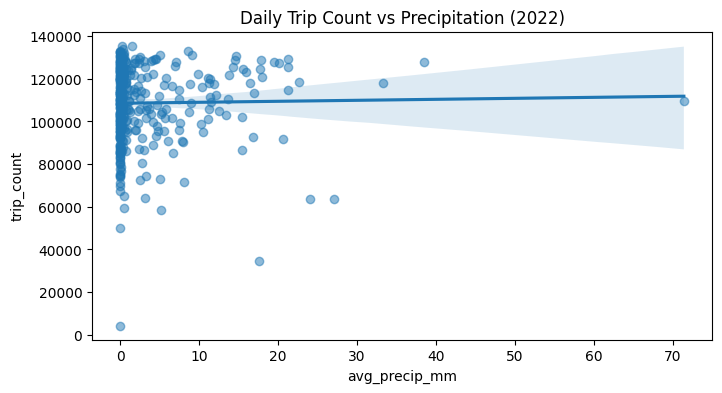

Year 2022:
  Pearson correlation avg_temp_c vs trip_count: 0.184 (p=0.000408)
  Pearson correlation avg_precip_mm vs trip_count: 0.017 (p=0.744)


In [10]:
c = Context()

years = [2018, 2020, 2022]

df_total_trips = []
df_top_holidays = []

for i, year in enumerate(years):
    print(f"--- Year: {year} ---")

    year_files = [f for f in reduced_files if f"year={year}" in f]
    ddf = dd.read_parquet(year_files, engine="pyarrow")

    # Convert categorical columns to string to avoid issues
    def convert_categoricals(df):
        cat_cols = [col for col, dt in df.dtypes.items() if dt.name == 'category']
        if cat_cols:
            return df.astype({col: 'str' for col in cat_cols})
        return df
    ddf = ddf.map_partitions(convert_categoricals)

    # Add pandemic_period column
    if year == 2018:
        period = "Pre-pandemic"
    elif year == 2020:
        period = "During pandemic"
    elif year == 2022:
        period = "Post-pandemic"
    else:
        period = "Other"
    ddf = ddf.assign(pandemic_period=period)

    ddf = ddf.persist()

    try:
        c.drop_table(f"taxi_data_{year}")
    except KeyError:
        pass

    c.create_table(f"taxi_data_{year}", ddf)


    # Total trips holiday vs non-holiday
    sql1 = f"""
    SELECT pandemic_period, is_holiday, COUNT(*) AS trip_count
    FROM taxi_data_{year}
    GROUP BY pandemic_period, is_holiday
    ORDER BY pandemic_period, is_holiday DESC
    """
    start = time.time()
    df1 = c.sql(sql1).compute()
    print(f"Dask-SQL query took {time.time() - start:.2f}s")
    df1['year'] = year
    df_total_trips.append(df1)

    # Top 5 holidays
    sql2 = f"""
    SELECT holiday_name, COUNT(*) AS trip_count
    FROM taxi_data_{year}
    WHERE is_holiday = TRUE
    GROUP BY holiday_name
    ORDER BY trip_count DESC
    LIMIT 5
    """
    start = time.time()
    df2 = c.sql(sql2).compute()
    print(f"Dask-SQL query took {time.time() - start:.2f}s")
    df2['year'] = year
    df_top_holidays.append(df2)

    # Weather impact: daily avg temp & precip vs trip counts
    sql3 = f"""
    SELECT
      pickup_date,
      AVG(avg_temp_c) AS avg_temp_c,
      AVG(precip_mm) AS avg_precip_mm,
      COUNT(*) AS trip_count
    FROM taxi_data_{year}
    WHERE pickup_date IS NOT NULL
    GROUP BY pickup_date
    ORDER BY pickup_date
    """
    start = time.time()
    df3 = c.sql(sql3).compute()
    print(f"Dask-SQL query took {time.time() - start:.2f}s")

    # Plot correlations with regression lines
    plt.figure(figsize=(8,4))
    sns.regplot(data=df3, x='avg_temp_c', y='trip_count', scatter_kws={'alpha':0.5})
    plt.title(f'Daily Trip Count vs Avg Temperature ({year})')
    plt.show()

    plt.figure(figsize=(8,4))
    sns.regplot(data=df3, x='avg_precip_mm', y='trip_count', scatter_kws={'alpha':0.5})
    plt.title(f'Daily Trip Count vs Precipitation ({year})')
    plt.show()

    # Pearson correlations
    temp_corr, temp_p = pearsonr(df3['avg_temp_c'], df3['trip_count'])
    precip_corr, precip_p = pearsonr(df3['avg_precip_mm'], df3['trip_count'])
    print(f"Year {year}:")
    print(f"  Pearson correlation avg_temp_c vs trip_count: {temp_corr:.3f} (p={temp_p:.3g})")
    print(f"  Pearson correlation avg_precip_mm vs trip_count: {precip_corr:.3f} (p={precip_p:.3g})")

    # Drop table to save memory
    c.drop_table(f"taxi_data_{year}")


# Comparison

In [14]:
import os

def get_year_file_sizes(files, years):
    sizes = {}
    for year in years:
        year_files = [f for f in files if f"year={year}" in f]
        total_bytes = sum(os.path.getsize(f) for f in year_files)
        sizes[year] = total_bytes / (1024**3)  # convert to GB
    return sizes

year_sizes_gb = get_year_file_sizes(reduced_files, years)
print(year_sizes_gb)


{2018: 1.673160843551159, 2020: 0.4766652211546898, 2022: 0.7980123460292816}


In [18]:
df_times['Data_Size_GB'] = df_times['Year'].map(year_sizes_gb)
df_times['DuckDB_Time_per_GB'] = df_times['DuckDB_Time_s'] / df_times['Data_Size_GB']
df_times['DaskSQL_Time_per_GB'] = df_times['DaskSQL_Time_s'] / df_times['Data_Size_GB']

/tmp/ipykernel_2044630/1357533798.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt_norm, x='Year', y='Time_per_GB_s', hue='Engine', ci=None, palette='muted', edgecolor='.2')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


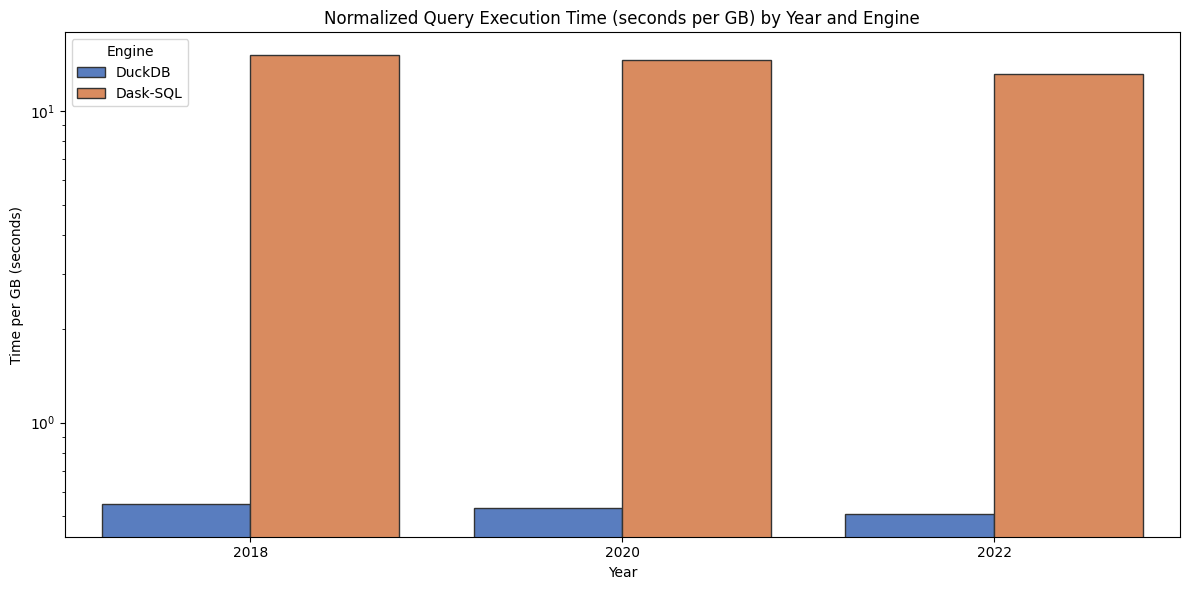

In [19]:
df_melt_norm = df_times.melt(
    id_vars=['Year', 'Query'], 
    value_vars=['DuckDB_Time_per_GB', 'DaskSQL_Time_per_GB'],
    var_name='Engine', value_name='Time_per_GB_s'
)

df_melt_norm['Engine'] = df_melt_norm['Engine'].map({
    'DuckDB_Time_per_GB': 'DuckDB',
    'DaskSQL_Time_per_GB': 'Dask-SQL'
})

plt.figure(figsize=(12,6))
sns.barplot(data=df_melt_norm, x='Year', y='Time_per_GB_s', hue='Engine', ci=None, palette='muted', edgecolor='.2')
plt.title("Normalized Query Execution Time (seconds per GB) by Year and Engine")
plt.ylabel("Time per GB (seconds)")
plt.xlabel("Year")
plt.yscale("log")
plt.legend(title='Engine')
plt.tight_layout()
plt.show()


# Comparisons Across File types and Libraries

In [28]:
def convert_categoricals_to_str(ddf):
    cat_cols = [col for col, dtype in ddf.dtypes.items() if str(dtype).startswith("category")]
    if cat_cols:
        return ddf.astype({col: "string" for col in cat_cols})
    return ddf

def create_table_no_filepath(c, table_name, ddf):
    ddf = ddf.persist()
    try:
        c.create_table(table_name, ddf)
    except TypeError as e:
        if "'list' object cannot be converted to 'PyString'" in str(e):
            # Workaround: remove filepath attribute on _meta
            ddf2 = ddf.copy()
            ddf2._meta = ddf2._meta.copy()
            if hasattr(ddf2._meta, "filepath"):
                delattr(ddf2._meta, "filepath")
            c.create_table(table_name, ddf2)
        else:
            raise

def run_perf_tests(parquet_files_subset, csv_file_subset):
    results = []

    # 1. Pandas CSV
    start = time.time()
    df_csv = pd.read_csv(csv_file_subset)
    load_time = time.time() - start

    start = time.time()
    _ = df_csv.groupby('is_holiday')['tpep_pickup_datetime'].count()
    query_time = time.time() - start
    results.append({'method': 'Pandas CSV', 'load_s': load_time, 'query_s': query_time})

    # 2. Pandas Parquet
    start = time.time()
    df_parquet = pd.read_parquet(parquet_files_subset)
    load_time = time.time() - start

    start = time.time()
    _ = df_parquet.groupby('is_holiday')['tpep_pickup_datetime'].count()
    query_time = time.time() - start
    results.append({'method': 'Pandas Parquet', 'load_s': load_time, 'query_s': query_time})

    # 3. Dask CSV
    start = time.time()
    ddf_csv = dd.read_csv(csv_file_subset)
    load_time = time.time() - start

    start = time.time()
    _ = ddf_csv.groupby('is_holiday')['tpep_pickup_datetime'].count().compute()
    query_time = time.time() - start
    results.append({'method': 'Dask CSV', 'load_s': load_time, 'query_s': query_time})

    # 4. Dask Parquet
    start = time.time()
    ddf_parquet = dd.read_parquet(parquet_files_subset)
    load_time = time.time() - start

    start = time.time()
    _ = ddf_parquet.groupby('is_holiday')['tpep_pickup_datetime'].count().compute()
    query_time = time.time() - start
    results.append({'method': 'Dask Parquet', 'load_s': load_time, 'query_s': query_time})

    # 5. DuckDB Parquet
    con = duckdb.connect()
    start = time.time()
    query = f"""
    SELECT is_holiday, COUNT(*) AS trip_count
    FROM parquet_scan({parquet_files_subset})
    GROUP BY is_holiday
    """
    _ = con.execute(query).df()
    elapsed = time.time() - start
    # DuckDB combines load+query, so record all as query time, zero load time
    results.append({'method': 'DuckDB Parquet', 'load_s': 0, 'query_s': elapsed})

    # 6. Dask-SQL Parquet
    c = Context()
    ddf_sql = dd.read_parquet(parquet_files_subset)
    ddf_sql = convert_categoricals_to_str(ddf_sql)

    try:
        c.drop_table("taxi_subset")
    except KeyError:
        pass
    create_table_no_filepath(c, "taxi_subset", ddf_sql)

    start = time.time()
    sql = """
    SELECT is_holiday, COUNT(*) AS trip_count
    FROM taxi_subset
    GROUP BY is_holiday
    """
    _ = c.sql(sql).compute()
    query_time = time.time() - start
    results.append({'method': 'Dask-SQL Parquet', 'load_s': 0, 'query_s': query_time})

    return pd.DataFrame(results)

In [32]:
# Prepare subset files
subset_parquet_files = reduced_files[:5] 
subset_csv_file = "subset.csv"

if not os.path.exists(subset_csv_file):
    df_sub = pd.read_parquet(subset_parquet_files)
    df_sub.to_csv(subset_csv_file, index=False)

In [33]:
perf_df = run_perf_tests(subset_parquet_files, subset_csv_file)

/tmp/ipykernel_2044630/2750529252.py:27: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csv = pd.read_csv(csv_file_subset)


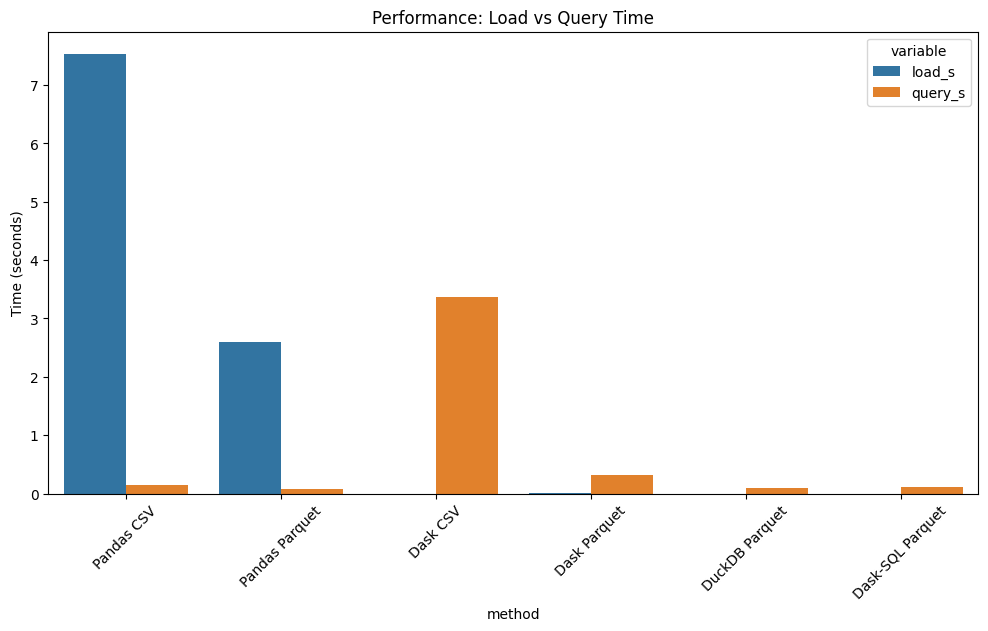

In [34]:
plt.figure(figsize=(12,6))
sns.barplot(data=perf_df.melt(id_vars='method', value_vars=['load_s', 'query_s']),
            x='method', y='value', hue='variable')
plt.ylabel("Time (seconds)")
plt.title("Performance: Load vs Query Time")
plt.xticks(rotation=45)
plt.show()

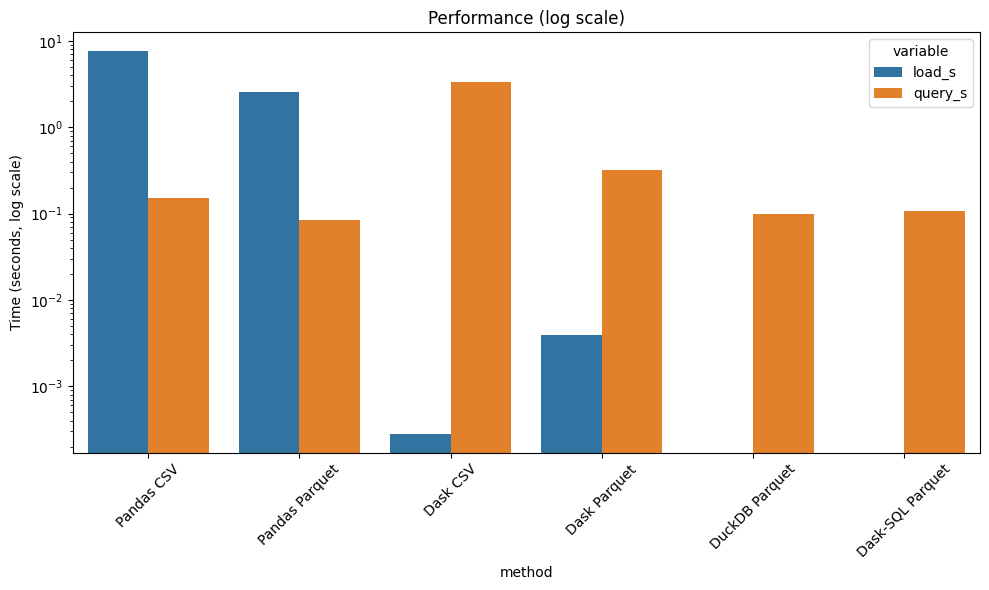

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(data=perf_df.melt(id_vars='method', value_vars=['load_s', 'query_s']),
            x='method', y='value', hue='variable')
plt.yscale('log')
plt.ylabel('Time (seconds, log scale)')
plt.title('Performance (log scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Pandas CSV has the longest load time (about 10 seconds), reflecting the inefficiency of loading CSVs. Query time is fast (0.15 seconds) once data is in memory.

Pandas Parquet loads faster (2 seconds) due to the columnar format, with a low query time (0.09 seconds).

Dask CSV shows negligible load time but a high query time (5 seconds), likely due to distributed overhead and CSV parsing costs.

Dask Parquet combines very fast loading (0.005 seconds) with moderate query time (0.2 seconds), benefiting from parallelism and efficient format.

DuckDB Parquet and Dask-SQL Parquet both load instantly and execute queries quickly (0.1 seconds), showing strong performance on Parquet files. DuckDB is often slightly faster due to lower overhead.

# Conclusions

- Parquet is clearly the preferred file format for performance, especially when combined with tools designed for efficient on-disk queries like DuckDB and Dask-SQL.

- While Pandas CSV is easy to use, it has a significant performance penalty on load.

- Dask offers scalable, parallel computation but requires care with data types and can show slower query execution on some tasks.

- DuckDB and Dask-SQL provide a great balance of speed and flexibility for exploratory SQL querying on large datasets without needing to fully load data into memory. Although DaskSQL took significantly more time to set up. 